# These are the Cartography visuals.

# Imports Section 

In [1]:
import sys
sys.path.append("../notebooks/scripts/")

In [2]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive, scatterplot_with_tooltip
from Helpers import get_y_positions

%matplotlib inline

In [3]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [4]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 120
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rc('text', usetex=False)

In [5]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [ ]:
colors = snakemake.input.colors
node_df = snakemake.input.node_df

pca_df = snakemake.input.pca_df
explained_variance_pca = snakemake.input.explained_variance_pca

mds_df = snakemake.input.mds_df
tsne_df = snakemake.input.tsne_df
umap_df = snakemake.input.umap_df

#Scatterplot:
scatterplot_pca = snakemake.input.scatterplot_pca
scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

scatterplot_mds = snakemake.input.scatterplot_mds
scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

scatterplot_tsne = snakemake.input.scatterplot_tsne
scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

scatterplot_umap = snakemake.input.scatterplot_umap
scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

In [12]:
clades_to_plot = ['3c', '3c2', '3c2.A', '3c3', '3c3.A', '3c3.B','A1','A1a','A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A2', 'A2/re', 'A3', 'A4'] 
domain =  ['3c', '3c2', '3c2.A', '3c3', '3c3.A', '3c3.B','A1','A1a','A1b', 'A1b/131K','A1b/135K', 'A1b/135N', 'A2', 'A2/re', 'A3', 'A4'] 
range_ = ['#6626d4', '#4138c3', '#4e70ff', '#5499ff', '#61b8f0', '#5499ff', '#87dfb3','#a0e994', '#bdee78', '#ddee64', '#f8e957', '#ffdb4e', '#ffc348', '#ff9e40', '#ff6e36','#dc2f24']

# Reading in all the data from the scripts

In [13]:
node_df = pd.read_csv(node_df, sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)
node_df = node_df.take(node_df["clade_membership"].dropna().index.values.tolist())

In [14]:
node_df.head()

strain     date  pca1  pca2  pca3  pca4   mds1   mds2  \
0      A/Chungbuk/107/2016  2016.05 -1.65  4.99 -0.66 -0.63   2.63  20.76   
1  A/MUWRP-Uganda/579/2016  2016.67 -1.26  5.31 -0.79 -0.52  15.77  19.43   
2       A/Shiraz/1011/2015  2015.89 -1.55  5.24 -0.70 -0.59  -6.21  27.85   
3       A/Shiraz/1019/2016  2016.00 -1.70  5.24 -0.69 -0.66  -7.37  27.96   
4       A/Shiraz/1020/2016  2016.02 -1.70  5.24 -0.70 -0.65   6.82  21.80   

   tsne_x  tsne_y  ...  clade_membership  pca_label mds_label  umap_label  \
0   -2.41  -53.62  ...               3c3          2        -1           5   
1   -2.62  -53.56  ...               3c3          2        -1          10   
2   -1.63  -53.38  ...             3c3.B          2        -1          10   
3   -1.70  -53.40  ...               3c3          2        -1          10   
4   -1.73  -53.41  ...               3c3          2        -1          10   

   t-sne_label  pca_label_default  mds_label_default  umap_label_default  \
0           26                  2                 -1                  -1   
1           26                  2                 -1                 110   
2           26                  2                 -1                  -1   
3           26                  2                 -1                  -1   
4           26                  2                 -1                  24   

   t-sne_label_default  y  
0                   99  1  
1                   99  2  
2                   99  3  
3                   99  4  
4                   99  5  

[5 rows x 22 columns]

In [15]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [16]:
principalDf = pd.read_csv(pca_df, index_col=0)

In [17]:
explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df

explained variance  principal components
0              0.2646                     1
1              0.1746                     2
2              0.0847                     3
3              0.0564                     4
4              0.0293                     5
5              0.0247                     6
6              0.0208                     7
7              0.0170                     8
8              0.0147                     9
9              0.0112                    10

NameError: name 'snakemake' is not defined

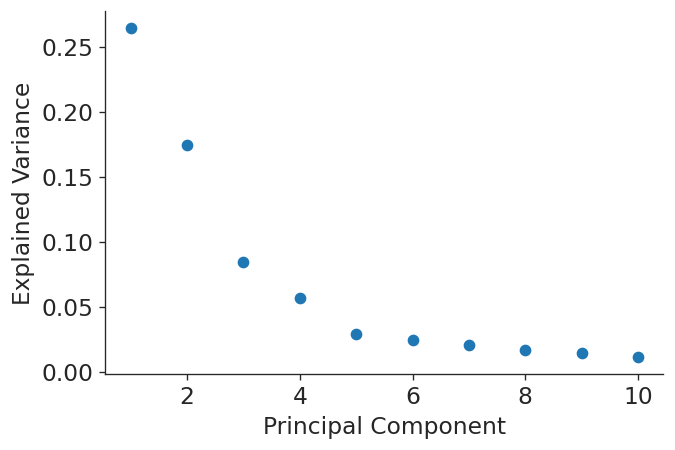

In [18]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.savefig(snakemake.output.Explained_variance_PCA)

In [19]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [20]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4      pca5  \
0      A/Alabama/06/2016 -0.022028  0.481156  1.903547 -0.552552  1.388025   
1      A/Florida/15/2016 -0.020995  0.485873  1.901220 -0.544951  1.396791   
2      A/Florida/35/2016 -0.022792  0.484288  1.900653 -0.548221  1.381645   
3  A/California/130/2015 -0.017834  0.481250  1.896358 -0.542818  1.379700   
4        A/Texas/19/2016 -0.021976  0.476846  1.896632 -0.545655  1.360729   

       pca6      pca7      pca8      pca9     pca10  pca_label  \
0 -1.935530  0.467764  0.056995  0.455920  1.238526          6   
1 -1.930615  0.477828  0.059965  0.454249  1.213760          6   
2 -1.924488  0.474538  0.049958  0.461770  1.225783          6   
3 -1.906120  0.462263  0.049863  0.431626  1.189365          6   
4 -1.898429  0.489786  0.054521  0.439162  1.200862          6   

   pca_label_default     date    y clade_membership clade_membership_color  
0                 31  2016.05  204            3c2.A                  3c2.A  
1                 31  2016.06  205            3c2.A                  3c2.A  
2                 31  2016.18  206            3c2.A                  3c2.A  
3                 31  2015.99  210            3c2.A                  3c2.A  
4                 31  2016.07  212            3c2.A                  3c2.A

In [21]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [22]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [23]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


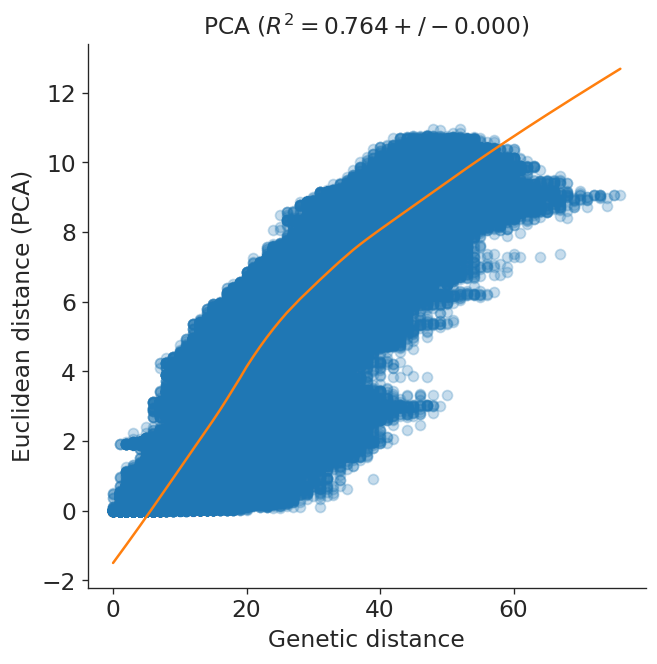

In [24]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)

#total_df_PCA = pd.read_csv("results/scatterplot_pca.csv",index_col=0)
#metadata_PCA = pd.read_csv("results/scatterplot_pca_metadata.csv", index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# Running MDS on the Dataset

In [25]:
MDS_df = pd.read_csv(mds_df, index_col=0)
#MDS_df = pd.read_csv("results/embed_mds_sequences.csv")

In [26]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [27]:
merged_mds_df

strain       mds1       mds2       mds3       mds4  \
0           A/Alabama/06/2016   1.985653   9.592859  -1.030677  -7.365683   
1           A/Florida/15/2016   1.865350   9.585983  -1.001429  -7.398926   
2           A/Florida/35/2016   4.115449  14.130094  -0.218860  -5.198244   
3       A/California/130/2015   0.797806   7.240344  -0.929087  -6.539927   
4             A/Texas/19/2016   0.779394   7.266683  -0.838050  -6.467870   
...                       ...        ...        ...        ...        ...   
1913     A/India/1736023/2017   4.974661 -25.960603   9.854918   4.268822   
1914     A/HongKong/3391/2017 -14.250256  12.639598   8.304575 -11.448911   
1915         A/Kenya/013/2017 -13.743681 -27.412238   9.614686   5.754197   
1916     A/India/1732610/2017 -16.295532 -28.227163  19.088146   9.847558   
1917  A/MUWRP-Uganda/579/2016  -7.151417   7.224443  11.422249 -37.225716   

      mds_label  mds_label_default     date     y clade_membership  \
0            15                 12  2016.05   204            3c2.A   
1            15                 12  2016.06   205            3c2.A   
2            15                 12  2016.18   206            3c2.A   
3            15                 12  2015.99   210            3c2.A   
4            15                 12  2016.07   212            3c2.A   
...         ...                ...      ...   ...              ...   
1913         -1                 -1  2017.79  1837         A1b/135K   
1914         -1                 -1  2017.52   462               A3   
1915         -1                 -1  2017.19  1605              A1b   
1916         -1                 -1  2017.68  1686         A1b/135N   
1917         -1                 -1  2016.67     2              3c3   

     clade_membership_color  
0                     3c2.A  
1                     3c2.A  
2                     3c2.A  
3                     3c2.A  
4                     3c2.A  
...                     ...  
1913               A1b/135K  
1914                     A3  
1915                    A1b  
1916               A1b/135N  
1917                    3c3  

[1918 rows x 11 columns]

In [28]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_12_mds

alt.Chart(...)

In [29]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [30]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


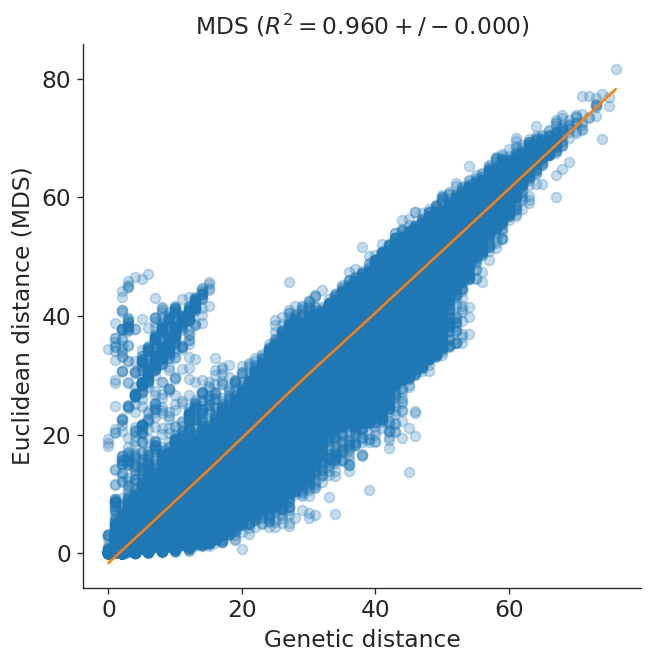

In [31]:
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)

#total_df_MDS = pd.read_csv("results/scatterplot_mds.csv",index_col=0)
#metadata_MDS = pd.read_csv("results/scatterplot_mds_metadata.csv", index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# Running T-SNE on the Dataset 

In [32]:
TSNE_df = pd.read_csv(tsne_df, index_col=0)

In [33]:
TSNE_df.head()

tsne_x     tsne_y  t-sne_label  t-sne_label_default
strain                                                                       
A/Alabama/06/2016     -29.902615  40.561905           20                   29
A/Florida/15/2016     -29.900515  40.561348           20                   29
A/Florida/35/2016     -29.598580  40.811024           20                   29
A/California/130/2015 -30.461636  40.021470           20                   29
A/Texas/19/2016       -30.459423  40.017216           20                   29

In [34]:
merged_tsne_df = TSNE_df.merge(
    node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]],
    on="strain"
)

In [35]:
merged_tsne_df.head()

strain     tsne_x     tsne_y  t-sne_label  \
0      A/Alabama/06/2016 -29.902615  40.561905           20   
1      A/Florida/15/2016 -29.900515  40.561348           20   
2      A/Florida/35/2016 -29.598580  40.811024           20   
3  A/California/130/2015 -30.461636  40.021470           20   
4        A/Texas/19/2016 -30.459423  40.017216           20   

   t-sne_label_default     date    y clade_membership clade_membership_color  
0                   29  2016.05  204            3c2.A                  3c2.A  
1                   29  2016.06  205            3c2.A                  3c2.A  
2                   29  2016.18  206            3c2.A                  3c2.A  
3                   29  2015.99  210            3c2.A                  3c2.A  
4                   29  2016.07  212            3c2.A                  3c2.A

In [36]:
scatterplot_with_tooltip_interactive(
    merged_tsne_df,
    'tsne_x',
    'tsne_y',
    'tsne_x',
    'tsne_y',
    ['strain', "clade_membership"],
    'clade_membership:N',
    domain,
    range_
)

alt.Chart(...)

In [37]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


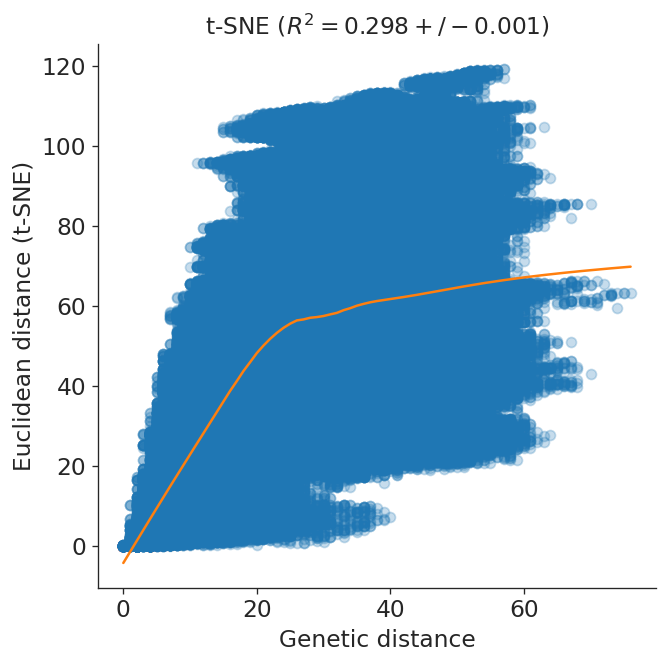

In [38]:
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# Running UMAP on the Dataset

In [39]:
UMAP_df = pd.read_csv(umap_df, index_col=0)

In [40]:
UMAP_df.head()

umap_x    umap_y  umap_label  umap_label_default
strain                                                                   
A/Alabama/06/2016      3.911999  1.625232           2                  15
A/Florida/15/2016      3.872653  1.518414           2                  15
A/Florida/35/2016      3.824510  0.687674           2                  15
A/California/130/2015  3.920955  2.244372           2                  15
A/Texas/19/2016        3.923950  2.265294           2                  15

In [41]:
merged_umap_df = UMAP_df.merge(
    node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]],
    on="strain"
)

In [42]:
merged_umap_df.head()

strain    umap_x    umap_y  umap_label  umap_label_default  \
0      A/Alabama/06/2016  3.911999  1.625232           2                  15   
1      A/Florida/15/2016  3.872653  1.518414           2                  15   
2      A/Florida/35/2016  3.824510  0.687674           2                  15   
3  A/California/130/2015  3.920955  2.244372           2                  15   
4        A/Texas/19/2016  3.923950  2.265294           2                  15   

      date    y clade_membership clade_membership_color  
0  2016.05  204            3c2.A                  3c2.A  
1  2016.06  205            3c2.A                  3c2.A  
2  2016.18  206            3c2.A                  3c2.A  
3  2015.99  210            3c2.A                  3c2.A  
4  2016.07  212            3c2.A                  3c2.A

In [43]:
scatterplot_with_tooltip_interactive(
    merged_umap_df,
    'umap_x',
    'umap_y',
    'umap_x',
    'umap_y',
    ['strain'],
    'clade_membership:N',
    domain,
    range_
)

alt.Chart(...)

In [44]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["strain:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap
#chart.save("../docs/UMAPMERSBrush.html")

alt.HConcatChart(...)

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


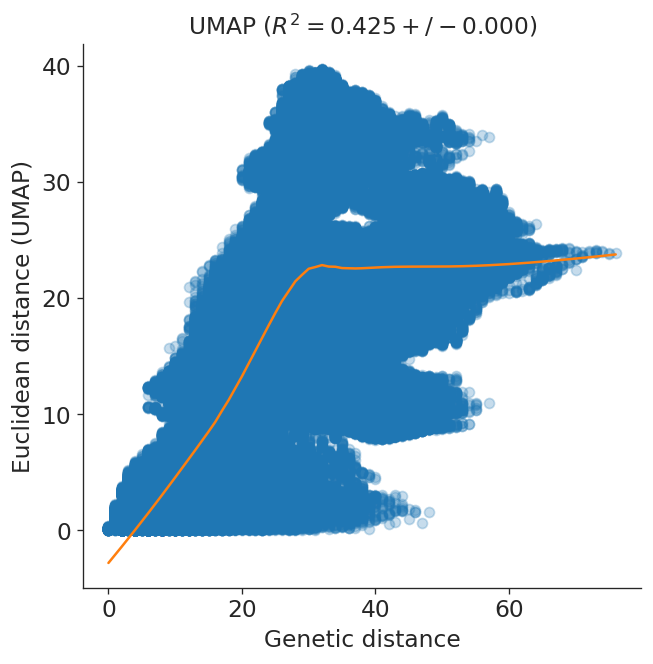

In [45]:
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# Linking all plots together clickable with Tree

In [46]:
merged_df = merged_pca_df.merge(
    MDS_df,
    on="strain",
).merge(
    TSNE_df,
    on="strain",
).merge(
    UMAP_df,
    on="strain",
)

In [47]:
merged_df.head()

strain      pca1      pca2      pca3      pca4      pca5  \
0      A/Alabama/06/2016 -0.022028  0.481156  1.903547 -0.552552  1.388025   
1      A/Florida/15/2016 -0.020995  0.485873  1.901220 -0.544951  1.396791   
2      A/Florida/35/2016 -0.022792  0.484288  1.900653 -0.548221  1.381645   
3  A/California/130/2015 -0.017834  0.481250  1.896358 -0.542818  1.379700   
4        A/Texas/19/2016 -0.021976  0.476846  1.896632 -0.545655  1.360729   

       pca6      pca7      pca8      pca9  ...  mds_label  mds_label_default  \
0 -1.935530  0.467764  0.056995  0.455920  ...         15                 12   
1 -1.930615  0.477828  0.059965  0.454249  ...         15                 12   
2 -1.924488  0.474538  0.049958  0.461770  ...         15                 12   
3 -1.906120  0.462263  0.049863  0.431626  ...         15                 12   
4 -1.898429  0.489786  0.054521  0.439162  ...         15                 12   

      tsne_x     tsne_y  t-sne_label t-sne_label_default    umap_x    umap_y  \
0 -29.902615  40.561905           20                  29  3.911999  1.625232   
1 -29.900515  40.561348           20                  29  3.872653  1.518414   
2 -29.598580  40.811024           20                  29  3.824510  0.687674   
3 -30.461636  40.021470           20                  29  3.920955  2.244372   
4 -30.459423  40.017216           20                  29  3.923950  2.265294   

   umap_label  umap_label_default  
0           2                  15  
1           2                  15  
2           2                  15  
3           2                  15  
4           2                  15  

[5 rows x 31 columns]

In [51]:
data = linking_tree_with_plots_brush(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain', 'clade_membership'],
    domain,
    range_
)

In [52]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)
save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

NameError: name 'snakemake' is not defined

In [53]:
fullChart

alt.VConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [70]:
import matplotlib.gridspec as gridspec
import numpy as np

In [71]:
#TODO: Reduce padding between panels in 4-panel scatterplot figures and add more ticks along x axis so readers can easily identify relevant thresholds in linear relationships.

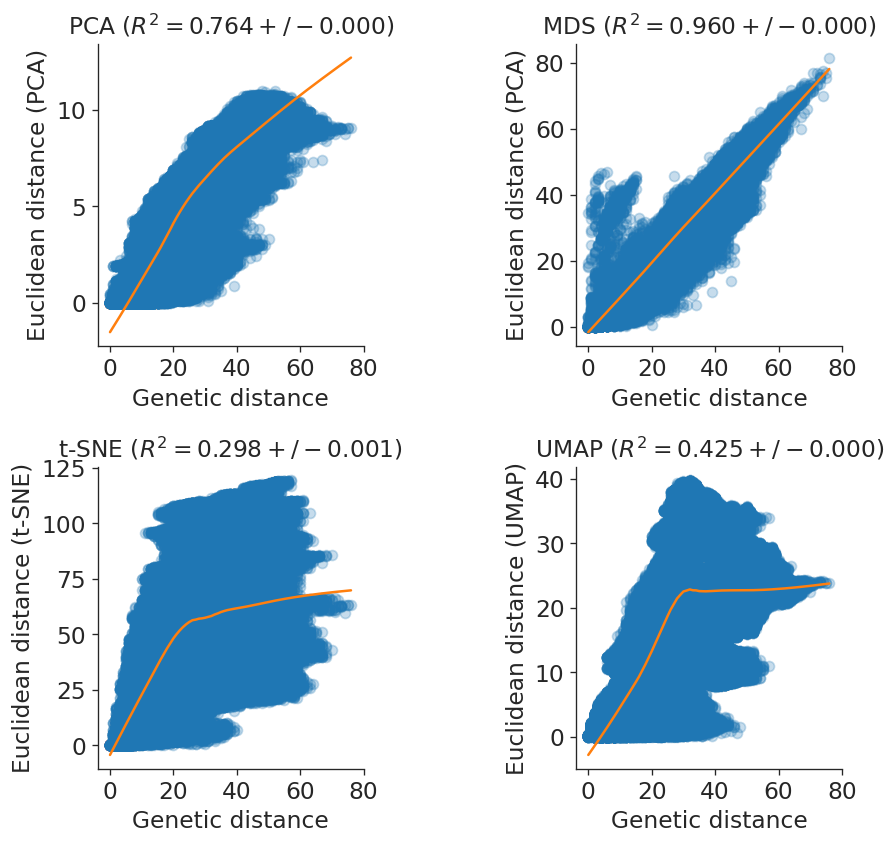

In [76]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.tight_layout(pad=4.0)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.8)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_xticks(np.arange(min(total_df_PCA["genetic"]), max(total_df_PCA["genetic"])+10, 20.0))
ax1.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_xticks(np.arange(min(total_df_MDS["genetic"]), max(total_df_MDS["genetic"])+10, 20.0))
ax2.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_xticks(np.arange(min(total_df_TSNE["genetic"]), max(total_df_TSNE["genetic"])+10, 20.0))
ax3.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_xticks(np.arange(min(total_df_UMAP["genetic"]), max(total_df_UMAP["genetic"])+10, 20.0))
ax4.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot, dpi=300)

# Supplemental Figures

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.PCA_Supplement)
save(chart, snakemake.output.PCA_Supplement_PNG)

# HDBSCAN Final Charts

In [ ]:
colors = pd.read_csv(colors, sep="\t", names=[i for i in range(0,101)])

In [ ]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [ ]:
PCA_df = pd.read_csv(pca_df,index_col=0)
MDS_df = pd.read_csv(mds_df,index_col=0)
TSNE_df = pd.read_csv(tsne_df,index_col=0)
UMAP_df = pd.read_csv(umap_df,index_col=0)
explained_variance_df = pd.read_csv(explained_variance_pca)

In [ ]:
merged_tsne_df = TSNE_df.merge(node_df[["strain", "date", "y", "clade_membership"]], on="strain")

In [ ]:
domain =  merged_tsne_df["t-sne_label"].drop_duplicates().values
range_ = colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
chart_12_tsne = scatterplot_with_tooltip_interactive(merged_tsne_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain','clade_membership', 't-sne_label'],'t-sne_label:N', domain, range_).properties(title="t-sne, optimal distance threshold")
domain = merged_tsne_df["t-sne_label_default"].drop_duplicates().values
range_ = colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
chart_12_default = scatterplot_with_tooltip_interactive(merged_tsne_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain','clade_membership', 't-sne_label'],'t-sne_label_default:N', domain, range_).properties(title="t-sne, default distance threshold")
domain = merged_tsne_df["clade_membership"].drop_duplicates().values
range_ = colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
chart_12_clade = scatterplot_with_tooltip_interactive(merged_tsne_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain','clade_membership', 't-sne_label'],'clade_membership:N', domain, range_).properties(title="t-sne, clade membership")
charts = alt.hconcat(chart_12_tsne,chart_12_default).resolve_scale(color='independent')
fullChart = alt.hconcat(charts, chart_12_clade).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.SupplementalTSNEHDBSCAN)
save(fullChart, snakemake.output.SupplementalTSNEHDBSCANPNG, scale_factor=2.0)

In [ ]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4 {method}5 {method}6 {method}7 {method}8 {method}9 {method}10".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [ ]:
merged_df = node_df[["strain", "date", "clade_membership", "y"]].merge(
    PCA_df,
    on="strain",
).merge(
    MDS_df,
    on="strain",
).merge(
    TSNE_df,
    on="strain",
).merge(
    UMAP_df,
    on="strain",
)

In [ ]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=merged_df, column_for_analysis="clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=merged_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [ ]:
domain =  sorted(merged_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush(
    merged_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','clade_membership', 'pca_label'],
    domain,
    range_
)
domain =  sorted(merged_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush(
    merged_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','clade_membership', 'mds_label'],
    domain,
    range_
)
domain =  sorted(merged_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush(
    merged_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','clade_membership', 't-sne_label'],
    domain,
    range_
)
domain =  sorted(merged_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush(
    merged_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','clade_membership', 'umap_label'],
    domain,
    range_
)

In [ ]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [ ]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.fullChartHDBSCAN)
save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)

In [ ]:
fullChart